In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

import gc
gc.enable()

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Checking GPU Functionality

In [2]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17572177766988402825
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2910112974
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17342830743188318819
 physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [4]:
tf.test.is_built_with_cuda()

True

# Import Data

In [2]:
filename = 'amazon_top_10_cats_50plus_ratings'
reviews = pd.read_pickle(filename + '.pkl')
print(reviews.shape)
reviews.head()

(13211253, 6)


,user_id,book_id,rating,review_text,title,category
83,A1DUEKGHT9F8GX,0001381733,5.0,gyo fujikawa is my favorite illustrator of thi...,a child's garden of verses,science fiction & fantasy
84,A11G2ZH0OXPNKV,0001381733,5.0,a child's garden of verses is a childhood stap...,a child's garden of verses,science fiction & fantasy
85,A23EB826EWC7EZ,0001381733,5.0,i have my father's book when he was a child bu...,a child's garden of verses,science fiction & fantasy
86,A1C0VN9HDW6MRS,0001381733,4.0,exactly like my childhood book. in very good s...,a child's garden of verses,science fiction & fantasy
87,A2EEX7S4T2HNCB,0001381733,5.0,"i had this book when i was a child, and all th...",a child's garden of verses,science fiction & fantasy


# Adding my own book ratings to the data
Might as well get some book recommendations out of this.

In [3]:
# keywords from some books i like
my_book_keywords = [
    'dresden',
    'mistborn',
    'expanse',
    'he who fights with monsters',
    'sandman slim',
    'stormlight archive',
    'dune'
    "galaxy's edge",
    'bobiverse',
    "wheel of time",
    'codex alera',
    'demon cycle',
    "ender's game",
    'song of ice and fire',
]
# creating a dataframe of the books i like and the ratings I give them (all 5's)
my_ratings_df = (
    reviews.loc[reviews.title.str.contains('|'.join(my_book_keywords))]
    .drop_duplicates(subset=['book_id'])
    .sort_values(by='title')
    .reset_index(drop=True)
    .assign(
        rating=5, 
        user_id='7777777' # created a unique user_id so I can recommend books to myself later
    )
)
# creating filler review_text in case something in the future doesn't like null values
my_ratings_df['review_text'] = 'this is my review text'
# reset column order to match reviews DF

print(my_ratings_df.shape)
my_ratings_df.head()

(65, 6)


,user_id,book_id,rating,review_text,title,category
0,7777777,0312857675,5,this is my review text,"a crown of swords (the wheel of time, book 7)",science fiction & fantasy
1,7777777,0002247402,5,this is my review text,"a dance with dragons (a song of ice and fire, #5)",science fiction & fantasy
2,7777777,0002247437,5,this is my review text,a feast for crows (song of ice and fire),genre fiction
3,7777777,0007450664,5,this is my review text,a song of ice and fire: the story so far (5 vo...,science fiction & fantasy
4,7777777,034554398X,5,this is my review text,a storm of swords (hbo tie-in edition): a song...,genre fiction


In [4]:
my_ratings_df.title[(my_ratings_df.category == 'genre fiction')|(my_ratings_df.category == 'science fiction & fantasy')].unique().tolist()

['a crown of swords (the wheel of time, book 7)',
 'a dance with dragons (a song of ice and fire, #5)',
 'a feast for crows (song of ice and fire)',
 'a song of ice and fire: the story so far (5 volumes)',
 'a storm of swords (hbo tie-in edition): a song of ice and fire: book three',
 'a storm of swords: part 2 blood and gold (a song of ice and fire, book 3)',
 "abaddon's gate (the expanse)",
 "academ's fury (codex alera, book 2)",
 'all these worlds (bobiverse)',
 'aloha from hell: a sandman slim novel',
 "babylon's ashes (the expanse)",
 'blood rites (the dresden files)',
 "caliban's war (the expanse)",
 "captain's fury (codex alera, book 4)",
 'changes (the dresden files)',
 'cibola burn (the expanse)',
 'cold days: a dresden files novel (the dresden files)',
 'dead beat (the dresden files)',
 'desert spear (the demon cycle)',
 'devil said bang: a sandman slim novel',
 "el juego de ender / ender's game (spanish edition)",
 "ender's game (the ender quintet)",
 "ender's game boxed set

In [5]:
keep_titles = [
'a crown of swords (the wheel of time, book 7)',
 'a dance with dragons (a song of ice and fire, #5)',
 'a feast for crows (song of ice and fire)',
 'a song of ice and fire: the story so far (5 volumes)',
 'a storm of swords (hbo tie-in edition): a song of ice and fire: book three',
 'a storm of swords: part 2 blood and gold (a song of ice and fire, book 3)',
 "abaddon's gate (the expanse)",
 "academ's fury (codex alera, book 2)",
 'all these worlds (bobiverse)',
 'aloha from hell: a sandman slim novel',
 "babylon's ashes (the expanse)",
 'blood rites (the dresden files)',
 "caliban's war (the expanse)",
 "captain's fury (codex alera, book 4)",
 'changes (the dresden files)',
 'cibola burn (the expanse)',
 'cold days: a dresden files novel (the dresden files)',
 'dead beat (the dresden files)',
 'desert spear (the demon cycle)',
 'devil said bang: a sandman slim novel',
 "ender's game (the ender quintet)",
 "ender's game boxed set i: ender's game, ender's shadow, shadow of the hegemon (the ender quintet)",
 "first lord's fury (codex alera, book 6)",
 'for we are many (bobiverse)',
 'furies of calderon (codex alera, book 1)',
 'ghost story (dresden files, no. 13)',
 'kill city blues: a sandman slim novel',
 'kill the dead. richard kadrey (sandman slim)',
 'killing pretty: a sandman slim novel',
 'mistborn trilogy boxed set (mistborn, the hero of ages, &amp; the well of ascension)',
 'nemesis games (the expanse)',
 'new spring: the novel (wheel of time)',
 'persepolis rising (the expanse)',
 "princeps' fury (codex alera, book 5)",
 'proven guilty (the dresden files)',
 'side jobs: stories from the dresden files',
 'small favor (the dresden files, book 10)',
 'the alloy of law: a mistborn novel',
 'the daylight war: book three of the demon cycle',
 "the ender quartet boxed set: ender's game, speaker for the dead, xenocide, children of the mind (the ender quintet)",
 "the expanse boxed set: leviathan wakes, caliban's war and abaddon's gate",
 'the final empire: mistborn book one',
 "the fires of heaven: book five of 'the wheel of time'",
 'the gathering storm (wheel of time, book 12)',
 'the getaway god: a sandman slim novel',
 'the path of daggers (the wheel of time, book 8)',
 'the perdition score: a sandman slim novel',
 'the skull throne: book four of the demon cycle',
 'the warded man: book one of the demon cycle',
 "the wheel of time, box set 3: books 7-9 (a crown of swords / the path of daggers / winter's heart)",
 'the wheel of time, boxed set ii, books 4-6: the shadow rising, the fires of heaven, lord of chaos',
 'towers of midnight (wheel of time, book thirteen)',
 'turn coat unabridged cd (the dresden files)',
 'we are legion (we are bob) (bobiverse)',
 'white night (the dresden files)',
 "winter's heart (the wheel of time, book 9)",
 'words of radiance: the stormlight archive book two'
]
my_ratings_df = my_ratings_df.loc[my_ratings_df.title.isin(keep_titles)]

In [6]:
# add my ratings into reviews dataframe
reviews = pd.concat([reviews,my_ratings_df]).reset_index(drop=True)
reviews.tail()

,user_id,book_id,rating,review_text,title,category
13211305,7777777,0143144723,5.0,this is my review text,turn coat unabridged cd (the dresden files),science fiction & fantasy
13211306,7777777,1536648884,5.0,this is my review text,we are legion (we are bob) (bobiverse),science fiction & fantasy
13211307,7777777,0143144731,5.0,this is my review text,white night (the dresden files),science fiction & fantasy
13211308,7777777,0312864256,5.0,this is my review text,"winter's heart (the wheel of time, book 9)",science fiction & fantasy
13211309,7777777,0575097418,5.0,this is my review text,words of radiance: the stormlight archive book...,science fiction & fantasy


# Input Conversion
  + the model will not be able to handle the user_id and book_id string values.
  + need to convert them to numeric
    + user_id has letters in it so I will need to create new ID's
    + book_id can just be converted to a numeric datatype

In [7]:
unique_user_id_list = reviews.user_id.unique().tolist() # unique list of user_id's
user_id_map = pd.Series(range(len(unique_user_id_list)), index=unique_user_id_list).to_dict() # mapping each original user_id to a number

unique_book_id_list = reviews.book_id.unique().tolist() # unique list of book_id's
book_id_map = pd.Series(range(len(unique_book_id_list)), index=unique_book_id_list).to_dict() # mapping each original book_id to a number

# put numeric user_id's back into dataframe
reviews = (
    reviews
    .rename(columns={'user_id':'user_id_original','book_id':'book_id_original'})
    .assign(
        user_id = lambda df_: df_.user_id_original.map(user_id_map),
        book_id = lambda df_: df_.book_id_original.map(book_id_map)
    )
)

reviews

,user_id_original,book_id_original,rating,review_text,title,category,user_id,book_id
0,A1DUEKGHT9F8GX,0001381733,5.0,gyo fujikawa is my favorite illustrator of thi...,a child's garden of verses,science fiction & fantasy,0,0
1,A11G2ZH0OXPNKV,0001381733,5.0,a child's garden of verses is a childhood stap...,a child's garden of verses,science fiction & fantasy,1,0
2,A23EB826EWC7EZ,0001381733,5.0,i have my father's book when he was a child bu...,a child's garden of verses,science fiction & fantasy,2,0
3,A1C0VN9HDW6MRS,0001381733,4.0,exactly like my childhood book. in very good s...,a child's garden of verses,science fiction & fantasy,3,0
4,A2EEX7S4T2HNCB,0001381733,5.0,"i had this book when i was a child, and all th...",a child's garden of verses,science fiction & fantasy,4,0
...,...,...,...,...,...,...,...,...
13211305,7777777,0143144723,5.0,this is my review text,turn coat unabridged cd (the dresden files),science fiction & fantasy,5366100,4930
13211306,7777777,1536648884,5.0,this is my review text,we are legion (we are bob) (bobiverse),science fiction & fantasy,5366100,48973
13211307,7777777,0143144731,5.0,this is my review text,white night (the dresden files),science fiction & fantasy,5366100,4915
13211308,7777777,0312864256,5.0,this is my review text,"winter's heart (the wheel of time, book 9)",science fiction & fantasy,5366100,8024


In [9]:
# update data on local
reviews.to_pickle(filename + '.pkl')

In [21]:
# my new personal user_id for later use
my_user_id = reviews.user_id[reviews.user_id_original == '7777777'].unique()[0]
my_user_id

5366100

In [22]:
book_n = reviews.book_id.nunique()
user_n = reviews.user_id.nunique()
print('Nunique books:',book_n)
print('Nunique users:',user_n)

Nunique books: 64998
Nunique users: 5366101


# Modeling

In [23]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [24]:
# build model
#MLP

output_dim = 10 # larger number = higher capacity model prone to overfitting - extends training time

# book embedding layer
input_books = Input(shape=[1], name='book_input')
embed_books = Embedding(book_n + 1, output_dim, name='book_embed')(input_books)
embed_books_output = Flatten(name='book_embed_output')(embed_books)

# user embedding layer
input_users = Input(shape=[1], name='user_input')
embed_users = Embedding(user_n + 1, output_dim, name='user_embed')(input_users)
embed_users_output = Flatten(name='user_embed_output')(embed_users)

concat = Concatenate()([embed_books_output, embed_users_output])
concat_dropout = Dropout(0.2)(concat)
dense1 = Dense(128, activation='relu')(concat_dropout)
dense1_dropout = Dropout(0.2)(dense1)
dense2 = Dense(64, activation='relu')(dense1_dropout)
dense2_dropout = Dropout(0.2)(dense2)

output = Dense(1, name='output', activation='relu')(dense2_dropout)

model = Model(inputs=[input_books, input_users], outputs=output)

optimizer = Adam()

model.compile(
    optimizer=optimizer, 
    loss='mean_squared_error'
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 book_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 book_embed (Embedding)         (None, 1, 10)        649990      ['book_input[0][0]']             
                                                                                                  
 user_embed (Embedding)         (None, 1, 10)        53661020    ['user_input[0][0]']             
                                                                                              

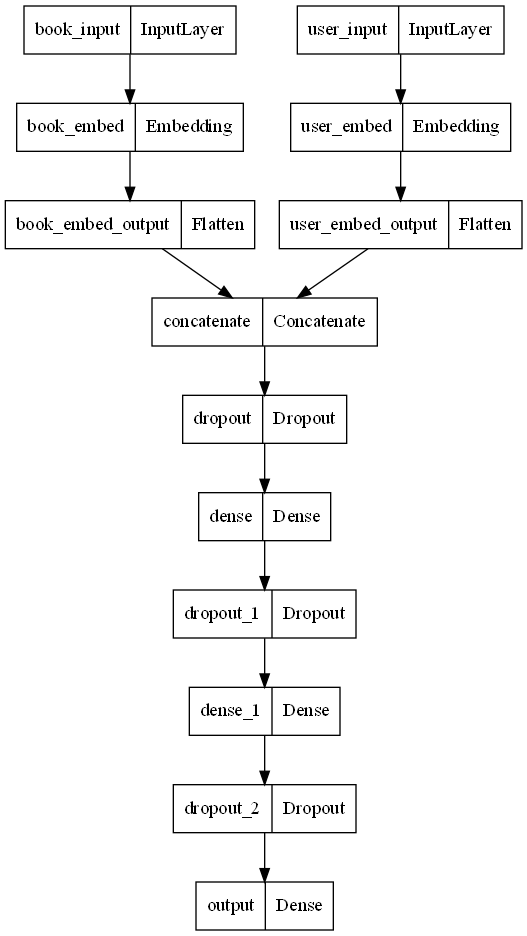

In [25]:
plot_model(model)

In [26]:
%%time

# fit model
history = model.fit(
    [reviews.book_id, reviews.user_id], reviews.rating,
    batch_size=256,
    epochs=5,
    verbose=1,
)

# save model
model.save('model_' + filename + '_' + '.h5')

Epoch 1/5
51607/51607 [==============================] - 4636s 90ms/step - loss: 0.8722
Epoch 2/5
51607/51607 [==============================] - 4671s 91ms/step - loss: 0.6266
Epoch 3/5
51607/51607 [==============================] - 4666s 90ms/step - loss: 0.5516
Epoch 4/5
51607/51607 [==============================] - 4627s 90ms/step - loss: 0.5130
Epoch 5/5
51607/51607 [==============================] - 4663s 90ms/step - loss: 0.4913
CPU times: total: 6h 42min 55s
Wall time: 6h 27min 44s
